In [90]:
# -*- coding: utf-8 -*-
from hyperparams import Hyperparams as hp
import os
import codecs
from jamo import h2j, j2hcj
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [2]:
trascript = hp.transcript_pos
lines = codecs.open(trascript, 'r', 'utf-8').readlines()

In [3]:
def load_vocab():
    char2idx = {char: idx for idx, char in enumerate(hp.vocab)}
    idx2char = {idx: char for idx, char in enumerate(hp.vocab)}
    return char2idx, idx2char

In [39]:
fnames, texts, secs, text_lengths = [], [], [], []
char2idx, idx2char = load_vocab();

for line in tqdm(lines):
    line = j2hcj(line)
    fname, _, text, sec = line.strip().split('|')
    encodedText = [char2idx[char] for char in text]
    encodedText = np.array(encodedText, np.int32).tostring()
    fnames.append(fname); texts.append(encodedText)
    secs.append(float(sec)); text_lengths.append(len(encodedText))
    
fnames = np.asarray(fnames)
texts = np.asarray(texts)
secs = np.asarray(secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12853/12853 [00:01<00:00, 10712.70it/s]


In [40]:
maxLen, minLen = max(text_lengths), min(text_lengths)

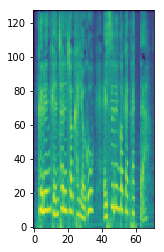

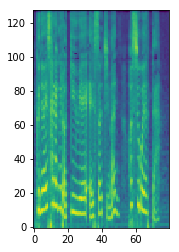

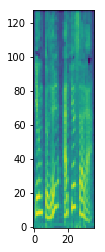

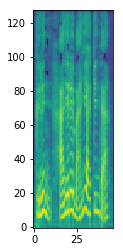

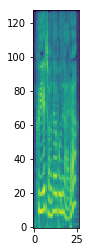

In [121]:


for i in range(0, 5):
    fname = fnames[i]
    text = texts[i]
    
    fpath = os.path.join(hp.data_dir, fname)
    wav, fs = librosa.core.load(fpath, mono=True)
    nsc = np.int(fs/10)
    nov = np.int(fs/20)
    logSxx = spectrogram(wav, nsc, nov, fs)
    
    plt.imshow(logSxx, origin='lower')
    plt.show()
    
    
    

In [114]:
def spectrogram(wav, nsc, nov, fs):
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0)
    Sxx = abs(S)
    logSxx = 20 * np.log10(Sxx)
    
    
    return logSxx
    